In [ ]:
# !pip install -r ../requirements.txt

In [1]:
import pandas as pd

base_path = "../data/"  

orders = pd.read_csv(base_path + "olist_orders_dataset.csv")
reviews = pd.read_csv(base_path + "olist_order_reviews_dataset.csv")
items = pd.read_csv(base_path + "olist_order_items_dataset.csv")
customers = pd.read_csv(base_path + "olist_customers_dataset.csv")

print("orders:", orders.shape)
print("reviews:", reviews.shape)
print("items:", items.shape)
print("customers:", customers.shape)

orders.head()


orders: (99441, 8)
reviews: (99224, 7)
items: (112650, 7)
customers: (99441, 5)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [2]:
# print("=== ORDERS ===")
# print(orders.shape)
print(orders.dtypes)
# print(orders.isnull().sum())
# print(orders.nunique())
# print(orders.describe())
# print(orders.describe(include='object'))


order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object


In [3]:
# Convert dates to datetime format
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
orders["order_delivered_customer_date"] = pd.to_datetime(orders["order_delivered_customer_date"])
orders["order_estimated_delivery_date"] = pd.to_datetime(orders["order_estimated_delivery_date"])

# Calculate total number of orders and last order date per customer
customer_orders = orders.groupby("customer_id").agg(
    total_orders=("order_id", "nunique"),
    last_order_date=("order_purchase_timestamp", "max")
).reset_index()

customer_orders.head()


,customer_id,total_orders,last_order_date
0,00012a2ce6f8dcda20d059ce98491703,1,2017-11-14 16:08:26
1,000161a058600d5901f007fab4c27140,1,2017-07-16 09:40:32
2,0001fd6190edaaf884bcaf3d49edf079,1,2017-02-28 11:06:43
3,0002414f95344307404f0ace7a26f1d5,1,2017-08-16 13:09:20
4,000379cdec625522490c315e70c7a9fb,1,2018-04-02 13:42:17


In [4]:
orders_reviews = pd.merge(orders, reviews, on="order_id", how="inner")


In [5]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [6]:
avg_review_scores = orders_reviews.groupby("customer_id").agg(
    avg_review_score=("review_score", "mean")
).reset_index()


In [7]:
customer_summary = pd.merge(customer_orders, avg_review_scores, on="customer_id", how="left")
customer_summary.head()


,customer_id,total_orders,last_order_date,avg_review_score
0,00012a2ce6f8dcda20d059ce98491703,1,2017-11-14 16:08:26,1.0
1,000161a058600d5901f007fab4c27140,1,2017-07-16 09:40:32,4.0
2,0001fd6190edaaf884bcaf3d49edf079,1,2017-02-28 11:06:43,5.0
3,0002414f95344307404f0ace7a26f1d5,1,2017-08-16 13:09:20,5.0
4,000379cdec625522490c315e70c7a9fb,1,2018-04-02 13:42:17,4.0


In [8]:
# Delivery delay = actual delivery date - estimated delivery date
orders["delivery_delay_days"] = (orders["order_delivered_customer_date"] - orders["order_estimated_delivery_date"]).dt.days


In [9]:
avg_delay = orders.groupby("customer_id").agg(
    avg_delivery_delay=("delivery_delay_days", "mean")
).reset_index()


In [10]:
customer_summary = pd.merge(customer_summary, avg_delay, on="customer_id", how="left")
customer_summary.head()


,customer_id,total_orders,last_order_date,avg_review_score,avg_delivery_delay
0,00012a2ce6f8dcda20d059ce98491703,1,2017-11-14 16:08:26,1.0,-6.0
1,000161a058600d5901f007fab4c27140,1,2017-07-16 09:40:32,4.0,-10.0
2,0001fd6190edaaf884bcaf3d49edf079,1,2017-02-28 11:06:43,5.0,-16.0
3,0002414f95344307404f0ace7a26f1d5,1,2017-08-16 13:09:20,5.0,-1.0
4,000379cdec625522490c315e70c7a9fb,1,2018-04-02 13:42:17,4.0,-5.0


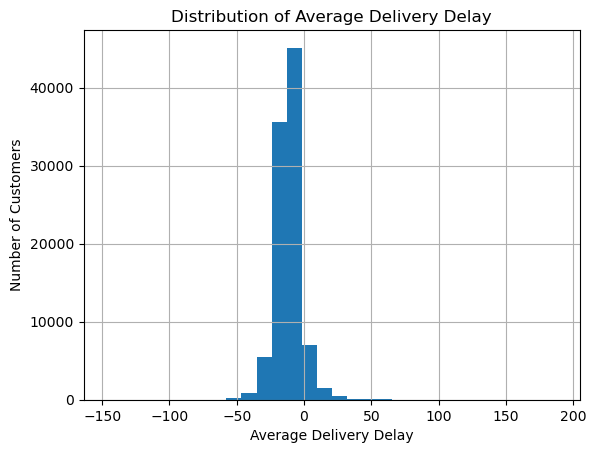

In [12]:
import matplotlib.pyplot as plt

customer_summary['avg_delivery_delay'].hist(bins=30)
plt.xlabel('Average Delivery Delay')
plt.ylabel('Number of Customers')
plt.title('Distribution of Average Delivery Delay')
plt.show()


In [ ]:
# import sys
# !{sys.executable} -m pip install textblob


In [ ]:
# import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

In [ ]:
# pip install deep-translator


In [13]:
from textblob import TextBlob
from deep_translator import GoogleTranslator

def get_sentiment_v2(text):
    if pd.isnull(text) or text.strip() == "":
        return None
    try:
        translated = GoogleTranslator(source='auto', target='en').translate(text)
        return TextBlob(translated).sentiment.polarity
    except:
        return None


In [14]:
from tqdm.auto import tqdm
tqdm.pandas()

sample_reviews = reviews.sample(100, random_state=42).copy()
sample_reviews["sentiment_score"] = sample_reviews["review_comment_message"].progress_apply(get_sentiment_v2)


  0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
sample_reviews["review_comment_message"].isnull().sum()

60

In [20]:
from deep_translator import GoogleTranslator

def try_translate(text):
    if pd.isnull(text) or text.strip() == "":
        return None
    try:
        return GoogleTranslator(source='auto', target='en').translate(text)
    except:
        return None

# 원문과 번역 컬럼 추가
sample_reviews["translated_comment"] = sample_reviews["review_comment_message"].apply(try_translate)

# 앞 100개만 보기
sample_reviews[["review_comment_message", "translated_comment"]].head(100)


,review_comment_message,translated_comment
90252,NaN,None
24436,Cumpriu o acordado!,Fulfilled the awake!
11313,NaN,None
75442,NaN,None
7217,NaN,None
...,...,...
49440,NaN,None
51584,NaN,None
14411,"Caixa amassada e rasgada, e ainda não entregar...","Cash and torn, and have not yet delivered to m..."
31646,NaN,None


In [27]:
total_by_score = reviews.groupby('review_score').size()

In [29]:
text_by_score = reviews[reviews['review_comment_message'].notnull()].groupby('review_score').size()

In [30]:
text_ratio = (text_by_score / total_by_score).fillna(0).round(2)

In [31]:
comparison_df = pd.DataFrame({
    'Total Reviews': total_by_score,
    'Reviews with Text': text_by_score,
    'Text Review Ratio': text_ratio
})

print(comparison_df)

              Total Reviews  Reviews with Text  Text Review Ratio
review_score                                                     
1                     11424               8745               0.77
2                      3151               2145               0.68
3                      8179               3557               0.43
4                     19142               5976               0.31
5                     57328              20554               0.36


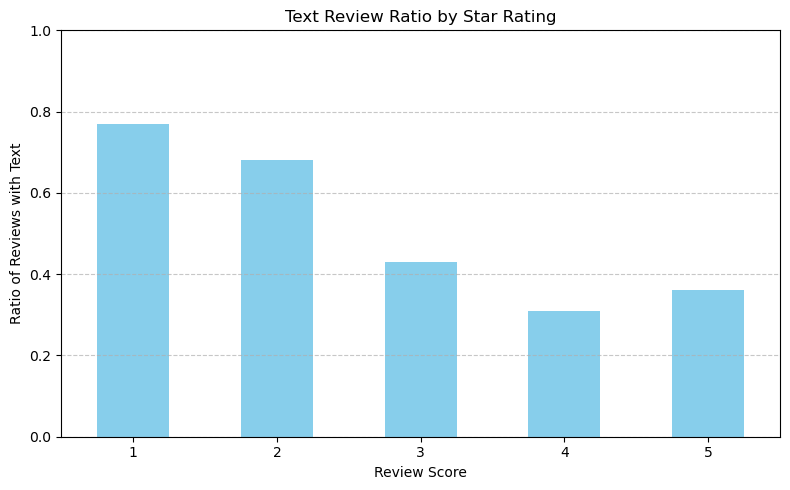

In [32]:
plt.figure(figsize=(8, 5))
text_ratio.sort_index().plot(kind='bar', color='skyblue')

plt.title('Text Review Ratio by Star Rating')
plt.xlabel('Review Score')
plt.ylabel('Ratio of Reviews with Text')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()